In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import scipy.stats as st
from scipy import stats
from sklearn.neighbors import NearestCentroid
import numpy as np
import seaborn as sns

np.random.seed(41)

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.set_figure_params(figsize=None)

In [4]:
# Read pre-processed data
adata_train = sc.read_h5ad('../../data/GSE_158055_COVID19_TRAIN.h5ad')
adata_test = sc.read_h5ad('../../data/GSE_158055_COVID19_TEST.h5ad')

# Concatenate the train and test adata into one adata.
adata_concat = adata_train.concatenate(adata_test, batch_categories=['ref', 'new'])
adata = adata_concat.copy()

del adata_concat

/home/dozonok/anaconda3/envs/workshop_scanpy_2/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


### Get centroids of each samples

In [5]:
basis_values = adata.obsm['X_umap']
sample_vector = adata.obs['sampleID_label'].values
#covid_non_covid_vector = adata.obs['covid_non_covid'].values
batch_vector = adata.obs['batch'].values

x_basis_value = []
y_basis_value = []

for b_v in basis_values:
    x_basis_value.append(b_v[0])
    y_basis_value.append(b_v[1])

df = pd.DataFrame(list(zip(basis_values, sample_vector, batch_vector, x_basis_value, y_basis_value)),
               columns =['basis_value', 'sample', 'batch', 'x_basis_value', 'y_basis_value'])
df.head()

X = np.stack(df.basis_value.values.tolist()[:])
y = df['sample'].tolist()
clf = NearestCentroid()
clf.fit(X, y)

del basis_values
del sample_vector
del batch_vector
del x_basis_value
del y_basis_value


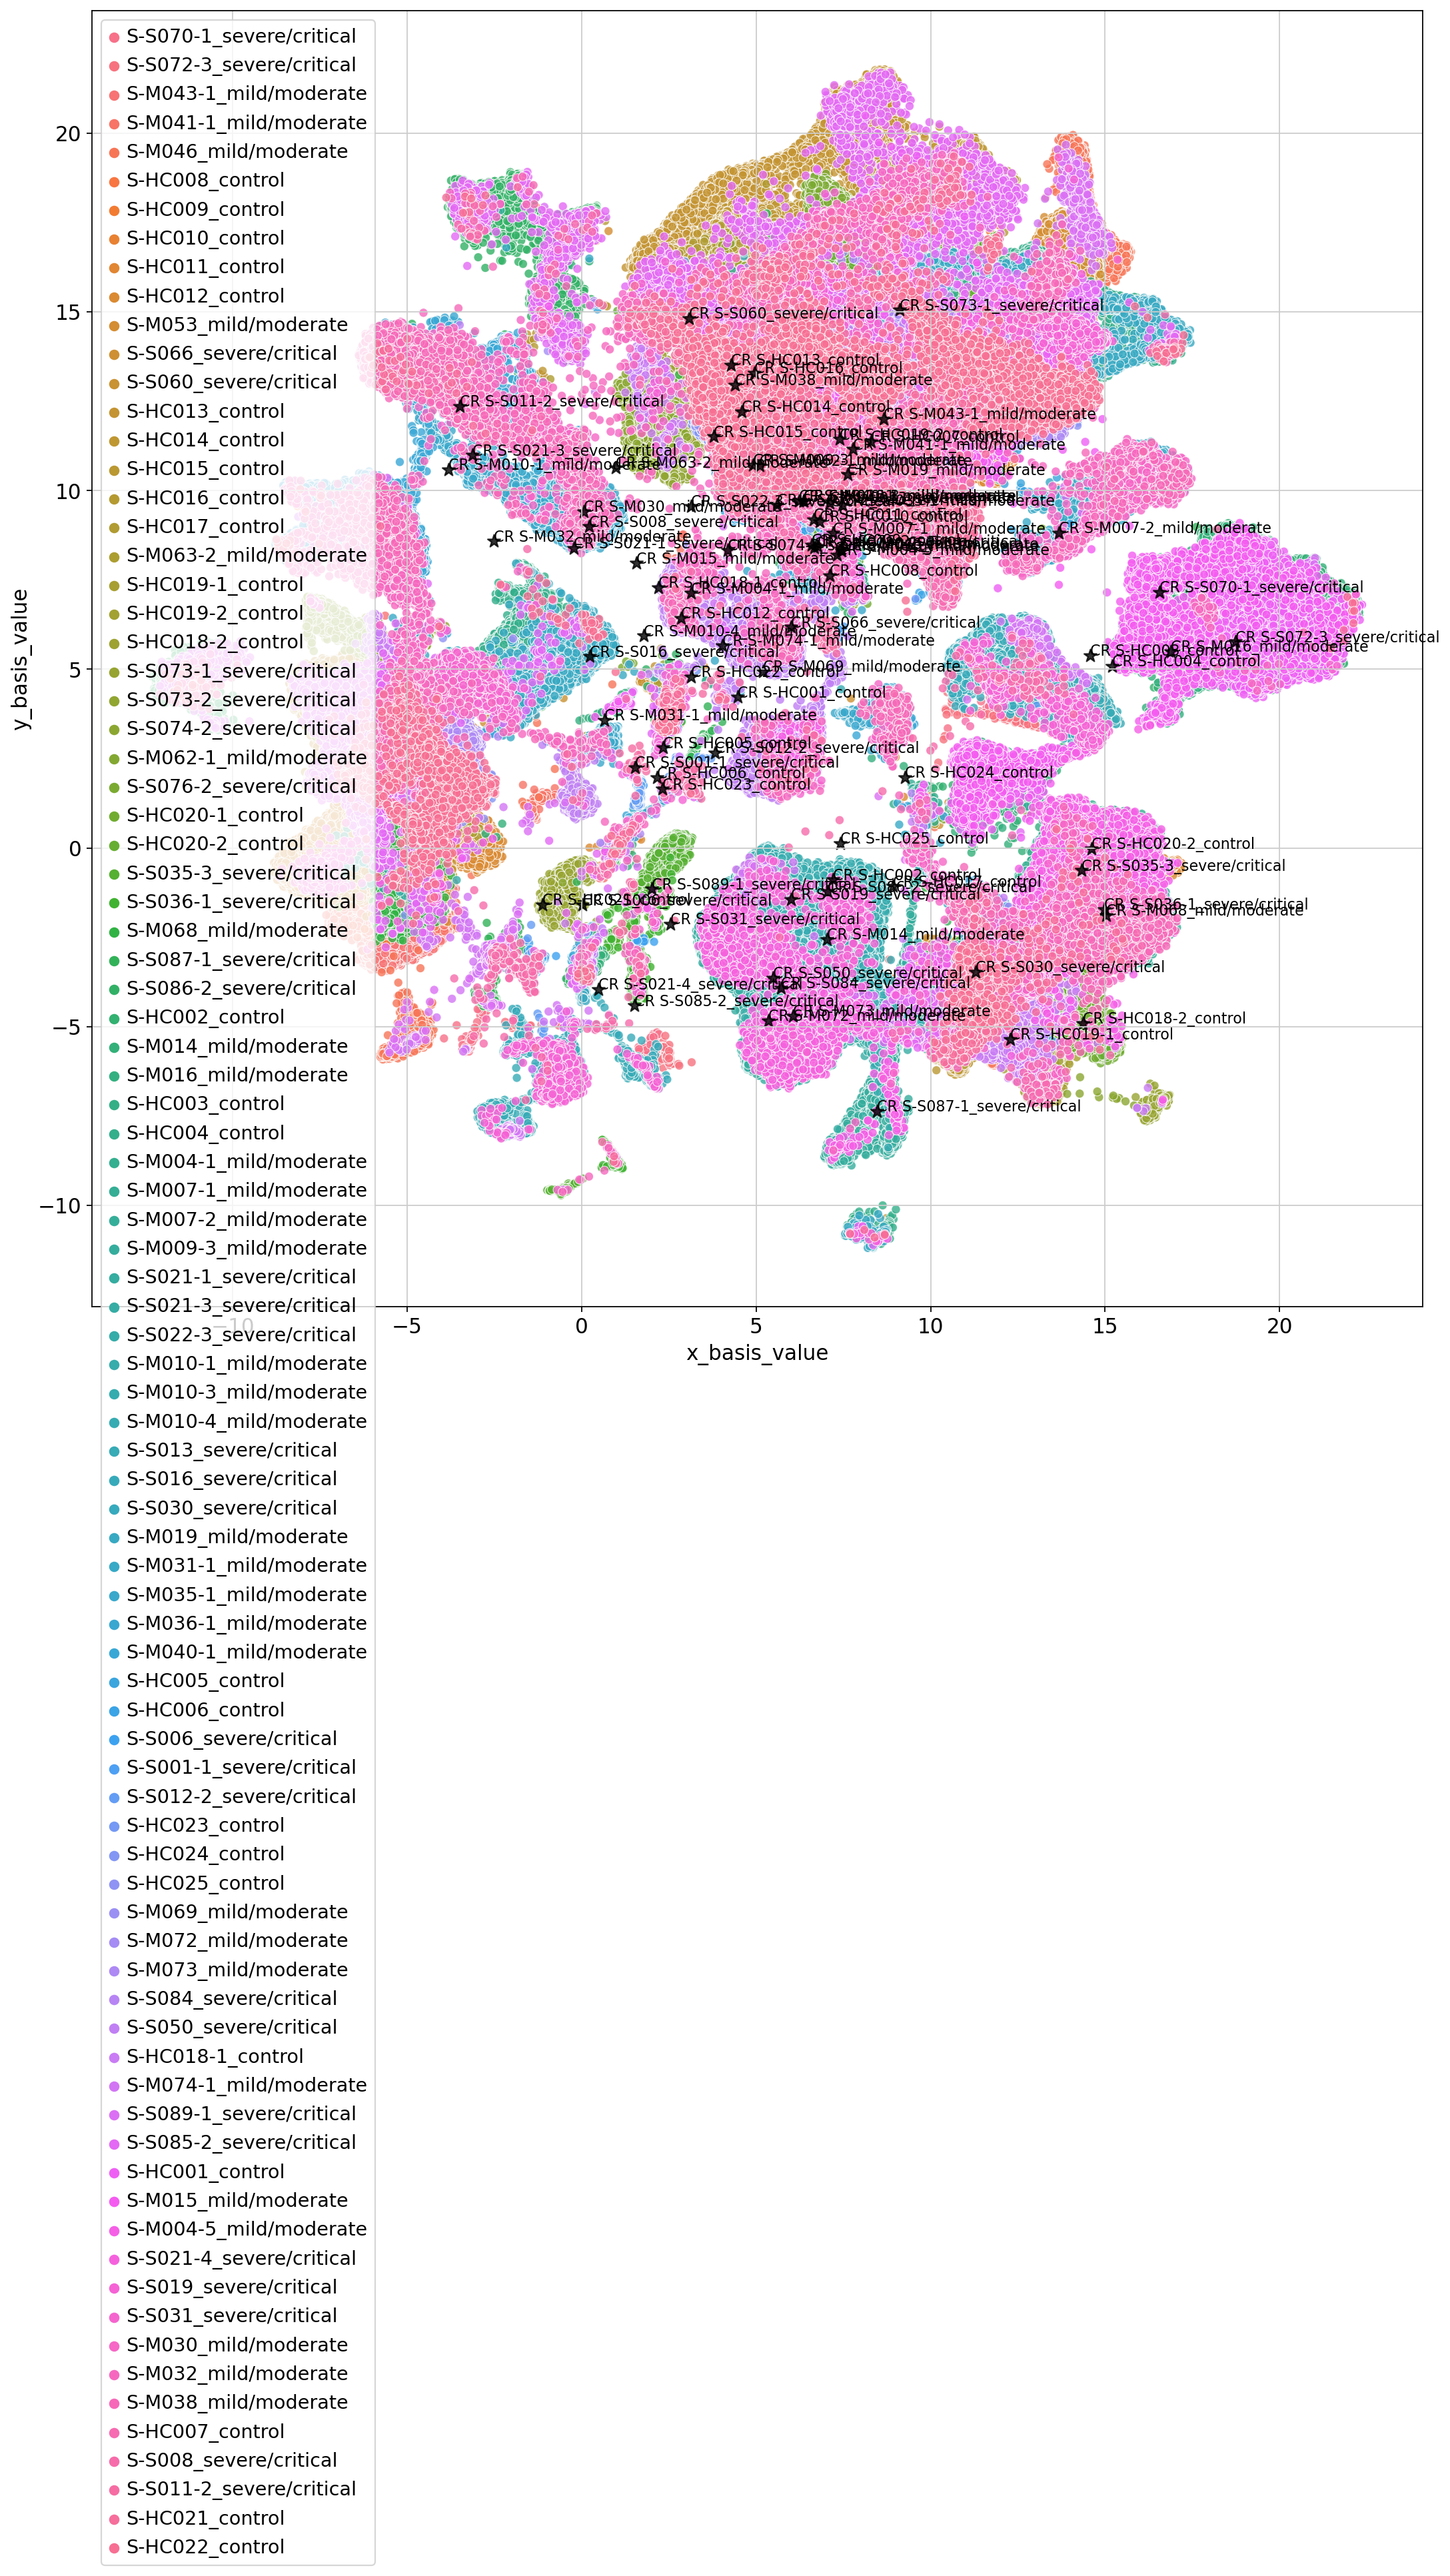

In [7]:
list_samples = df['sample'].unique()
sns.scatterplot(x='x_basis_value', y='y_basis_value', data=df, hue='sample', alpha=0.8)
#sns.lmplot(x='x_basis_value', y='y_basis_value', data=df, hue='sample', fit_reg=False)

centroid_id = 0
for centroid in clf.centroids_:
    plt.scatter(centroid[0], centroid[1], s=80, alpha=0.8, marker="*", color='black')
    plt.text(centroid[0], centroid[1], f'CR {list_samples[centroid_id]}', color='black', fontsize=10)
    centroid_id+= 1

# Show the plot
sc.set_figure_params(figsize=(16, 16))
plt.legend(loc="best")
plt.savefig("./output_figures/GSE158055_samples_centroids.pdf", format="pdf")
plt.show()

## Sample Classification: Scenario 2.1

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get centroids of each sample's cluster (covid and ctrl samples). When we get a new sample, count the nearest centroids of each cell in a new sample. And make a result based on the count (either `covid` or `non_covid`)

In [16]:
# from sklearn.model_selection import train_test_split

# y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=7777)
y_train = np.unique(df.query("batch == 'ref'")['sample'].values)
y_test = np.unique(df.query("batch == 'new'")['sample'].values)

print("Samples for getting centroids of existing samples (covid and non-covid):", y_train)
print("Samples for testing:", y_test) 
print()
print("Length of train samples:", len(y_train))
print("Length of test samples:", len(y_test))

Samples for getting centroids of existing samples (covid and non-covid): ['S-HC002_control' 'S-HC003_control' 'S-HC004_control' 'S-HC005_control'
 'S-HC006_control' 'S-HC008_control' 'S-HC009_control' 'S-HC010_control'
 'S-HC011_control' 'S-HC012_control' 'S-HC013_control' 'S-HC014_control'
 'S-HC015_control' 'S-HC016_control' 'S-HC017_control' 'S-HC018-2_control'
 'S-HC019-1_control' 'S-HC019-2_control' 'S-HC020-1_control'
 'S-HC020-2_control' 'S-HC023_control' 'S-HC024_control' 'S-HC025_control'
 'S-M004-1_mild/moderate' 'S-M007-1_mild/moderate'
 'S-M007-2_mild/moderate' 'S-M009-3_mild/moderate'
 'S-M010-1_mild/moderate' 'S-M010-3_mild/moderate'
 'S-M010-4_mild/moderate' 'S-M014_mild/moderate' 'S-M016_mild/moderate'
 'S-M019_mild/moderate' 'S-M031-1_mild/moderate' 'S-M035-1_mild/moderate'
 'S-M036-1_mild/moderate' 'S-M040-1_mild/moderate'
 'S-M041-1_mild/moderate' 'S-M043-1_mild/moderate' 'S-M046_mild/moderate'
 'S-M053_mild/moderate' 'S-M062-1_mild/moderate' 'S-M063-2_mild/moderate'

In [18]:
y_train = list(y_train)
df_exist = df.query("sample == @y_train")
#df_exist

Get centroids of each existing samples.

In [19]:
X = np.stack(df_exist.basis_value.values.tolist()[:])
y = df_exist['sample'].tolist()
clf = NearestCentroid()
clf.fit(X, y)

NearestCentroid()

Get the nearest centroids with new samples.

In [20]:
y_test = list(y_test)
df_new = df.query("sample == @y_test")
#df_new

X_new = np.stack(df_new.basis_value.values.tolist()[:])
y_new = df_new['sample'].tolist()

y_pred = []
for x_new in X_new:
    y_pred.append(clf.predict([x_new]))

y_pred = np.squeeze(np.stack(y_pred[:]))

Count how many the nearest centroids of covid sample/non-covid samples has the new sample obtained.

In [21]:
from collections import Counter

beginning = 0
samples_range = dict()

y_pred_agg = []
y_true_agg = []

for sample in df_new['sample'].unique():
    # Assing a new label (either covid or non_covid sample))
    if "mild/moderate" in sample or "severe/critical" in sample:
        y_true_agg.append('covid')
    else:
        y_true_agg.append('non_covid')
    samples_range[sample] = [beginning, beginning+len(df_new[df_new['sample'] == sample].index.to_list())]
    beginning = len(df_new[df_new['sample'] == sample].index.to_list())+beginning


# Get count of each new samples
for s, r in samples_range.items():
    print(f"Testing {s}")
    tmp_y_pred = y_pred[r[0]:r[1]]
    # count_detected_samples_key = list(Counter(tmp_y_pred).keys())
    # count_detected_samples = list(Counter(tmp_y_pred).values())
    count_pred_samples = Counter(tmp_y_pred)

    covid_sample_counter = 0
    non_covid_sample_counter = 0
    for s, count in count_pred_samples.items():
        if "mild/moderate" in s or "severe/critical" in s:
            covid_sample_counter+=count
        else:
            non_covid_sample_counter+=count
    
    if covid_sample_counter>non_covid_sample_counter:
        y_pred_agg.append('covid')
    else:
        y_pred_agg.append('non_covid')

Testing S-HC018-1_control
Testing S-M074-1_mild/moderate
Testing S-S089-1_severe/critical
Testing S-S085-2_severe/critical
Testing S-HC001_control
Testing S-M015_mild/moderate
Testing S-M004-5_mild/moderate
Testing S-S021-4_severe/critical
Testing S-S019_severe/critical
Testing S-S031_severe/critical
Testing S-M030_mild/moderate
Testing S-M032_mild/moderate
Testing S-M038_mild/moderate
Testing S-HC007_control
Testing S-S008_severe/critical
Testing S-S011-2_severe/critical
Testing S-HC021_control
Testing S-HC022_control


In [22]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true_agg, y_pred_agg))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true_agg, y_pred_agg,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true_agg, y_pred_agg, average='micro'))

Accuracy: 0.9444444444444444
Precision: 0.9444444444444444
Recall: 0.9444444444444444


## Sample Classification: Scenario 2.2

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get centroids of each sample's cluster (covid and ctrl samples). When we get a new sample, we compute a centroid of each new sample. And compare them with those existing samples' centroids and then get distances between those existing samples and new samples. Then, sum the distances to the centroid of each new sample and the centroid of coronal and non-corona existing samples, separately for corona and non-corona. <br>
In the end, determine either the new sample is `covid` or `non_covid` based on the total distance with respect to covid and non-covid samples.

In [23]:
# Get a centroid of each sample
clf_new = NearestCentroid()
clf_new.fit(X_new, y_new)

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_

Calculate distance between new sample's centroids and exisitng one

In [37]:
distances = []

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_
list_exist_sample = df_exist['sample'].unique()

list_new_sample = df_new['sample'].unique()
# using zip() function to create a dictionary
# with keys and same length None value
dict_dist_results = {s: [] for s in list_new_sample}
# print(dict_dist_results)

for i in range(len(exist_sample_centroids)):
    print("---------------------")
    print("Exist sample:", list_exist_sample[i])
    #sample_key = list_exist_sample[i]
    for j in range (len(new_sample_centroids)):
        sample = list_new_sample[j]
        print('sample:', list_new_sample[j])
        dist = np.linalg.norm(np.array(exist_sample_centroids[i]) - np.array(new_sample_centroids[j]))
        print(dist)
        dict_dist_results[sample].append(dist)

---------------------
Exist sample: S-S070-1_severe/critical
sample: S-HC018-1_control
2.583734500944641
sample: S-M074-1_mild/moderate
12.43839218696999
sample: S-S089-1_severe/critical
11.962749292005302
sample: S-S085-2_severe/critical
13.688061284847022
sample: S-HC001_control
14.779654649590546
sample: S-M015_mild/moderate
7.7730818910135735
sample: S-M004-5_mild/moderate
4.173122535887503
sample: S-S021-4_severe/critical
11.924479652072966
sample: S-S019_severe/critical
14.689093147433269
sample: S-S031_severe/critical
16.056864187652288
sample: S-M030_mild/moderate
16.670371915252286
sample: S-M032_mild/moderate
17.562673923028463
sample: S-M038_mild/moderate
15.238983933145617
sample: S-HC007_control
13.566290814041125
sample: S-S008_severe/critical
16.238045993637527
sample: S-S011-2_severe/critical
14.705061502097493
sample: S-HC021_control
18.80107601177136
sample: S-HC022_control
15.630259047063296
---------------------
Exist sample: S-S072-3_severe/critical
sample: S-HC018

Get a label from checking the total distance of summing up the distance of exist covid sample and non covid sample between each ewn sample. <br>
<br>
And if the total distance to centroid with corona patient < the total distance to centroid with non corona patient<br>
-> The new sample is Corona (because the centroid of the new sample should be closer with the existing covid samples).<br>
Otherwise, The new sample is Non-covid.

In [38]:
covid_dist_total = 0
non_covid_dist_total = 0


new_dist_total = {s: {'covid': 0, 'non_covid': 0} for s in list_new_sample}

for i in range(len(list_exist_sample)):
    exist_sample = list_exist_sample[i]
    print(exist_sample)
    for new_s in dict_dist_results.keys():
        dist = dict_dist_results[new_s][i]
        if "mild/moderate" in exist_sample or "severe/critical" in exist_sample:
             new_dist_total[new_s]['covid'] += dist
        elif "control" in exist_sample:
            new_dist_total[new_s]['non_covid'] += dist

y_true_total_dist = []
y_pred_total_dist = []

for new_s, dist_total in new_dist_total.items():
    if "mild/moderate" in new_s or "severe/critical" in new_s:
        y_true_total_dist.append('covid')
    else:
        y_true_total_dist.append('non_covid')

    # Compare the total distance to centroid with corona & non corona samples    
    if dist_total['covid'] < dist_total['non_covid']:
        y_pred_total_dist.append('covid')
    else:
        y_pred_total_dist.append('non_covid')

S-S070-1_severe/critical
S-S072-3_severe/critical
S-M043-1_mild/moderate
S-M041-1_mild/moderate
S-M046_mild/moderate
S-HC008_control
S-HC009_control
S-HC010_control
S-HC011_control
S-HC012_control
S-M053_mild/moderate
S-S066_severe/critical
S-S060_severe/critical
S-HC013_control
S-HC014_control
S-HC015_control
S-HC016_control
S-HC017_control
S-M063-2_mild/moderate
S-HC019-1_control
S-HC019-2_control
S-HC018-2_control
S-S073-1_severe/critical
S-S073-2_severe/critical
S-S074-2_severe/critical
S-M062-1_mild/moderate
S-S076-2_severe/critical
S-HC020-1_control
S-HC020-2_control
S-S035-3_severe/critical
S-S036-1_severe/critical
S-M068_mild/moderate
S-S087-1_severe/critical
S-S086-2_severe/critical
S-HC002_control
S-M014_mild/moderate
S-M016_mild/moderate
S-HC003_control
S-HC004_control
S-M004-1_mild/moderate
S-M007-1_mild/moderate
S-M007-2_mild/moderate
S-M009-3_mild/moderate
S-S021-1_severe/critical
S-S021-3_severe/critical
S-S022-3_severe/critical
S-M010-1_mild/moderate
S-M010-3_mild/moder

In [39]:
dict_dist_results.keys

<function dict.keys>

In [40]:
y_true_total_dist

['non_covid',
 'covid',
 'covid',
 'covid',
 'non_covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'non_covid',
 'covid',
 'covid',
 'non_covid',
 'non_covid']

In [41]:
y_pred_total_dist

['non_covid',
 'non_covid',
 'non_covid',
 'non_covid',
 'non_covid',
 'non_covid',
 'non_covid',
 'non_covid',
 'non_covid',
 'non_covid',
 'non_covid',
 'non_covid',
 'non_covid',
 'non_covid',
 'non_covid',
 'non_covid',
 'non_covid',
 'non_covid']

Get Acc, precision, recall, and f1 score.

In [28]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true_total_dist, y_pred_total_dist))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true_total_dist, y_pred_total_dist,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true_total_dist, y_pred_total_dist, average='micro'))

Accuracy: 0.2777777777777778
Precision: 0.2777777777777778
Recall: 0.2777777777777778


## Sample Classification: Scenario 2.3

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get centroids of each sample's cluster (covid and non-covid samples). When we get a new sample, we compute a centroid of each new sample. And compare them with those existing samples' centroids, get the nearest centroids, and determine whether the new sample is covid or non_covid based on the nearest sample's centroid.

In [42]:
df

basis_value                    sample batch  \
0        [-3.3126068, -5.609095]  S-S070-1_severe/critical   ref   
1         [10.491699, 3.3476408]  S-S070-1_severe/critical   ref   
2         [1.8127815, -5.535585]  S-S070-1_severe/critical   ref   
3       [-3.2872899, -5.5972457]  S-S070-1_severe/critical   ref   
4         [1.7971826, -5.635811]  S-S070-1_severe/critical   ref   
...                          ...                       ...   ...   
485663    [11.576544, 13.771201]           S-HC022_control   new   
485664      [-3.98901, 1.123159]           S-HC022_control   new   
485665     [3.7583492, 12.19527]           S-HC022_control   new   
485666     [9.901998, 14.476457]           S-HC022_control   new   
485667     [3.4223125, 13.58736]           S-HC022_control   new   

        x_basis_value  y_basis_value  
0           -3.312607      -5.609095  
1           10.491699       3.347641  
2            1.812781      -5.535585  
3           -3.287290      -5.597246  
4            1.797183      -5.635811  
...               ...            ...  
485663      11.576544      13.771201  
485664      -3.989010       1.123159  
485665       3.758349      12.195270  
485666       9.901998      14.476457  
485667       3.422312      13.587360  

[485668 rows x 5 columns]

In [43]:
# Get a centroid of each sample
clf_new = NearestCentroid()
clf_new.fit(X_new, y_new)

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_

# result_dict = dict(zip(np.unique(np.array(y_new)),clf_new.centroids_))
# print(result_dict)

In [44]:
distances = []

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_
list_exist_sample = df_exist['sample'].unique()
list_new_sample = df_new['sample'].unique()

# using zip() function to create a dictionary
# with keys and same length None value
dict_dist_results = {s: [] for s in list_new_sample}
# print(dict_dist_results)

for i in range(len(exist_sample_centroids)):
    print("---------------------")
    print("Exist sample:", list_exist_sample[i])
    #sample_key = list_exist_sample[i]
    for j in range (len(new_sample_centroids)):
        sample = list_new_sample[j]
        print('sample:', list_new_sample[j])
        dist = np.linalg.norm(np.array(exist_sample_centroids[i]) - np.array(new_sample_centroids[j]))
        print(dist)
        dict_dist_results[sample].append(dist)

---------------------
Exist sample: S-S070-1_severe/critical
sample: S-HC018-1_control
2.583734500944641
sample: S-M074-1_mild/moderate
12.43839218696999
sample: S-S089-1_severe/critical
11.962749292005302
sample: S-S085-2_severe/critical
13.688061284847022
sample: S-HC001_control
14.779654649590546
sample: S-M015_mild/moderate
7.7730818910135735
sample: S-M004-5_mild/moderate
4.173122535887503
sample: S-S021-4_severe/critical
11.924479652072966
sample: S-S019_severe/critical
14.689093147433269
sample: S-S031_severe/critical
16.056864187652288
sample: S-M030_mild/moderate
16.670371915252286
sample: S-M032_mild/moderate
17.562673923028463
sample: S-M038_mild/moderate
15.238983933145617
sample: S-HC007_control
13.566290814041125
sample: S-S008_severe/critical
16.238045993637527
sample: S-S011-2_severe/critical
14.705061502097493
sample: S-HC021_control
18.80107601177136
sample: S-HC022_control
15.630259047063296
---------------------
Exist sample: S-S072-3_severe/critical
sample: S-HC018

In [45]:
dict_nearest_dist_idex = dict()
y_true_nearest = []
y_pred_nearest = []

for new_s, coords_centroid in dict_dist_results.items():
    nearest_sample_index = np.argmin(np.array(coords_centroid))
    nearest_sample = list_exist_sample[nearest_sample_index]

    # Assign a label to y_true
    if "mild/moderate" in new_s or "severe/critical" in new_s:
        y_true_nearest.append('covid')
    else:
        y_true_nearest.append('non_covid')
    
    # Assign a label to y_pred based on the nearest sample by distance
    if "mild/moderate" in nearest_sample or "severe/critical" in nearest_sample:
        y_pred_nearest.append('covid')
    else:
        y_pred_nearest.append('non_covid')


In [46]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true_nearest, y_pred_nearest))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true_nearest, y_pred_nearest,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true_nearest, y_pred_nearest, average='micro'))

Accuracy: 0.6111111111111112
Precision: 0.6111111111111112
Recall: 0.6111111111111112


## Sample Classification: Scenario 2.4

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get centroids of each sample's cluster (covid and non-covid samples). When we get a new sample, we compute a centroid of each new sample. And compare them with those existing samples' centroids, get k nearest centroids, and determine whether the new sample is covid or non_covid based on k nearest sample's centroid.

#### k=3

In [53]:
dict_nearest_dist_idex = dict()
y_true_k_nearest = []
y_pred_k_nearest = []
k = 3

# Get the k nearest samples
for new_s, coords_centroid in dict_dist_results.items():
    k_nearest_sample_index = np.argsort(coords_centroid)[:k]
    nearest_samples = list_exist_sample[k_nearest_sample_index]
    
    # Assign a label to y_true
    if "mild/moderate" in new_s or "severe/critical" in new_s:
        y_true_k_nearest.append('covid')
    else:
        y_true_k_nearest.append('non_covid')
    
    # Assign a label to y_pred based on the count of k nearest samples.
    covid_count = 0
    non_covid_count = 0

    for item in nearest_samples:
        if "mild/moderate" in item or "severe/critical" in item:
            covid_count += 1
        else:
            non_covid_count += 1
    
    if covid_count > non_covid_count:
        y_pred_k_nearest.append('covid')
    else:
        y_pred_k_nearest.append('non_covid')

In [54]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true_k_nearest, y_pred_k_nearest))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true_k_nearest, y_pred_k_nearest,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true_k_nearest, y_pred_k_nearest, average='micro'))

print("f1 score:", metrics.f1_score(y_true_k_nearest, y_pred_k_nearest, average='micro'))

Accuracy: 0.5555555555555556
Precision: 0.5555555555555556
Recall: 0.5555555555555556
f1 score: 0.5555555555555556


In [57]:
dict_nearest_dist_idex = dict()
y_true_k_nearest = []
y_pred_k_nearest = []
k = 5

# Get the k nearest samples
for new_s, coords_centroid in dict_dist_results.items():
    k_nearest_sample_index = np.argsort(coords_centroid)[:k]
    nearest_samples = list_exist_sample[k_nearest_sample_index]
    
    # Assign a label to y_true
    if "mild/moderate" in new_s or "severe/critical" in new_s:
        y_true_k_nearest.append('covid')
    else:
        y_true_k_nearest.append('non_covid')
    
    # Assign a label to y_pred based on the count of k nearest samples.
    covid_count = 0
    non_covid_count = 0

    for item in nearest_samples:
        if "mild/moderate" in item or "severe/critical" in item:
            covid_count += 1
        else:
            non_covid_count += 1
    
    if covid_count > non_covid_count:
        y_pred_k_nearest.append('covid')
    else:
        y_pred_k_nearest.append('non_covid')

In [58]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true_k_nearest, y_pred_k_nearest))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true_k_nearest, y_pred_k_nearest,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true_k_nearest, y_pred_k_nearest, average='micro'))

print("f1 score:", metrics.f1_score(y_true_k_nearest, y_pred_k_nearest, average='micro'))

Accuracy: 0.5
Precision: 0.5
Recall: 0.5
f1 score: 0.5
